In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.1-bin-hadoop2.7/
spark-3.0.1-bin-hadoop2.7/RELEASE
spark-3.0.1-bin-hadoop2.7/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/
spark-3.0.1-bin-hadoop2.7/examples/src/main/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop2.7/example

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

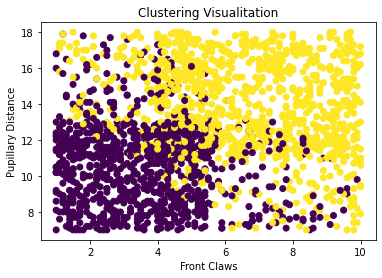

Accuracy: 83.5%


In [4]:
testing = spark.read.csv("BearTesting.csv", header = True, inferSchema = True)
training = spark.read.csv("BearTraining.csv", header = True, inferSchema = True)

columns = ["Front Claws", "Pupillary Distance", "Ear Shape"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")
training = training.select(columns)

from pyspark.sql.functions import when

testing = testing.withColumn(
    "Ear Shape",
    when(testing["Ear Shape"] == "Pointed", 0)
    .when(testing["Ear Shape"] == "Broad", 1)
    .otherwise(2)
)

testing = testing.withColumn(
    "Grizzly",
    when(testing["Grizzly"] == "No", 0)
    .otherwise(1)
)

training = training.withColumn(
    "Ear Shape",
    when(training["Ear Shape"] == "Pointed", 0)
    .when(training["Ear Shape"] == "Broad", 1)
    .otherwise(2)
)

from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=columns, outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()

plt.scatter(
    data["Front Claws"],
    data["Pupillary Distance"],
    c = data["prediction"]
)
plt.title("Clustering Visualitation")
plt.xlabel("Front Claws")
plt.ylabel("Pupillary Distance")
plt.show()

c = 0
for idx, row in data.iterrows():
  if row["Grizzly"] == row["prediction"]:
    c += 1

acc = c / len(data) * 100
print(f'Accuracy: {acc}%')